<a href="https://colab.research.google.com/github/JEN12H/PROJECTS/blob/main/MACHINE_TRANSLATION_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALLING NECESSARY PACKAGES

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text

In [ ]:
!pip install protobuf~=3.20.3

# INSTALLING DATASET FOR PORTUGUESE TO ENGLISH CONVERSION

In [ ]:
!pip install -q tensorflow_datasets

In [ ]:
!pip install -q tensorflow-text tensorflow==2.18.0

In [ ]:
!pip uninstall tensorflow-decision-forests tf-keras
!pip install tensorflow-decision-forests tf-keras

In [ ]:
!pip install -q -U tensorflow-text tensorflow

# IMPORTING NECESSARY MODULES

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

# EXTRACTING DATASET

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

# EXTRACTING THE TOKENIZER

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

In [ ]:
import os
import tensorflow as tf

# Print current working directory
print(os.getcwd())

# Download the SavedModel (if not already downloaded)
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

# Lo
tokenizers = tf.saved_model.load("/content/ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter")

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')] # THIS CODE IGNORES ALL THE PRIVATE METHODS

In [ ]:
print('> This is a batch of strings:') # HERE EN_EXAMPLES IS TENSOR SO WE CONVERT IT TO NUMPY
#  AND THEN DECODE IT TO CONVERT IT FROM BYTE STRING TO REGULAR ONE
for en in en_examples.numpy():
  print(en.decode('utf-8'))

In [ ]:
encoded = tokenizers.en.tokenize(en_examples)
# TOKENIZATION IS USED TO CONVERT HUMAN READABLE DATA INTO MACHINE READABLE FROM
print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

In [ ]:
round_trip = tokenizers.en.detokenize(encoded)
# DE-TOKENIZATION TO CONVERT TEXT BACK TO HUMAN READABLE FORM
print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

In [ ]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded) # CONVERTS TOKEN ID'S BACK TO TOKEN TEXT
tokens

In [ ]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

# SETTING UP DATA PIPELINE FOR OUR MODEL


1.   WE ARE PASSING OUR DATA AS TEXT IN
     INPUT IN FORM OF BATCHES AND THEN CONVERTING IT INTO EMBEDDINGS
2.   WE ARE USING RAGGED TENSOR - WHICH IS COMMONLY USED IN WHEN OUR LENGTH OF SENTENCES ARE DIFFERENT
3. RESTRICTING THE LENGTH OF INPUT TO 128
4. REMOVING START AND END TOKENS
5. TOKENIZING EVERY SENTENCE



In [ ]:
MAX_TOKENS = 128
def prepare_batch(pt,en):
  pt = tokenizers.pt.tokenize(pt) # THE OUTPUT IS RAGGED
  pt = pt[:,:MAX_TOKENS] # TRIMING OUR TENSORS TO MAX_TOKENS
  pt = pt.to_tensor() # CONVERTING TO PADDED TENSORS

  en = tokenizers.en.tokenize(en)
  en = en[:,:(MAX_TOKENS+1)]
  en = en.to_tensor()
  en_inputs = en[:,:-1] # DROPPING THE [END] TOKEN
  en_labels = en[:,1:]  # DROPPING  THE [START] TOKEN

  # Check for empty sequences in en_labels
  valid_examples = tf.reduce_any(en_labels != 0, axis=1)  # True for non-empty sequences
  pt = tf.boolean_mask(pt, valid_examples)  # Filter pt based on valid examples
  en_inputs = tf.boolean_mask(en_inputs, valid_examples)  # Filter en_inputs
  en_labels = tf.boolean_mask(en_labels, valid_examples)  # Filter en_labels

  return (pt,en_inputs), en_labels



In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# CREATING BATCHES OF OUR DATASET

*   INCLUDES OPERATIONS LIKE
*   1) SHUFFLING THE DATASET
*   2) map method is used to apply
       transformation to each and every data element
*   3) prefetch - The buffer_size
       parameter in .prefetch() controls how many batches to prepare ahead of time. It dictates how much data TensorFlow should load in parallel. The larger the buffer size, the more batches TensorFlow will preload.
*   4) AUTO TUNE -is used to let
       TensorFlow automatically determine the optimal settings for certain operations based on the system's resources (like CPU cores or memory availability).  



In [ ]:
def make_batches(ds):
  return (
      ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(prepare_batch,tf.data.AUTOTUNE).prefetch(buffer_size = tf.data.AUTOTUNE)
  )

In [ ]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

This is the same as the text generation tutorial, except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep. This is a simple and efficient way to train a text generation model. It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel

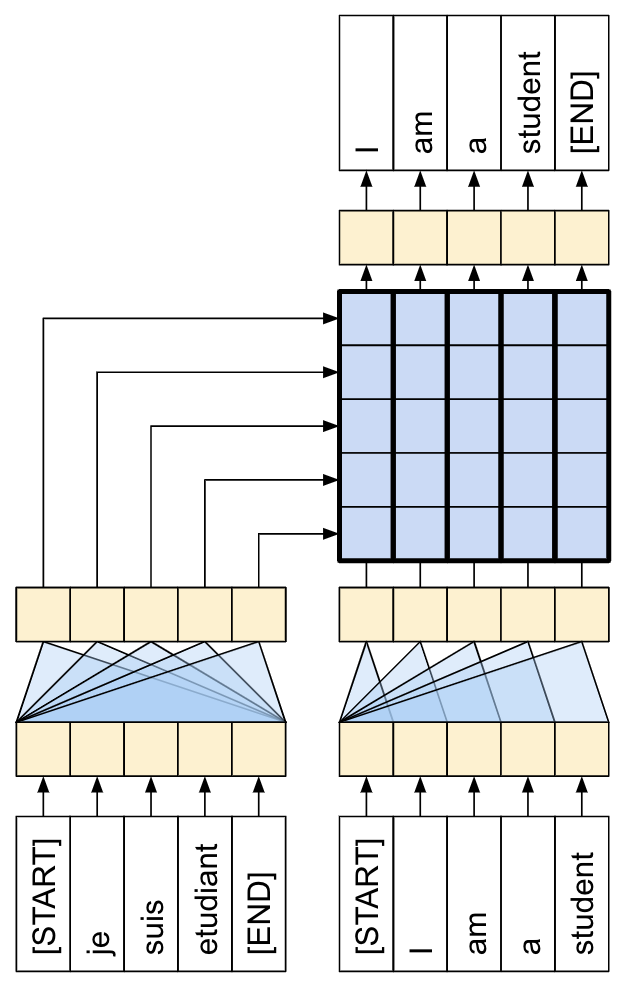

Given the Portuguese sequence, the model would try to generate the English sequence.

(the model can't get the end of a sentence right until it gets the beginning right), but it can give a more stable model because the model has to learn to correct its own errors during training.

In [ ]:
for (pt,en), en_labels in train_batches.take(1):
  break
print(pt.shape)
print(en.shape)
print(en_labels.shape)

In [ ]:
print(en[0][:10])
print(en_labels[0][:10])

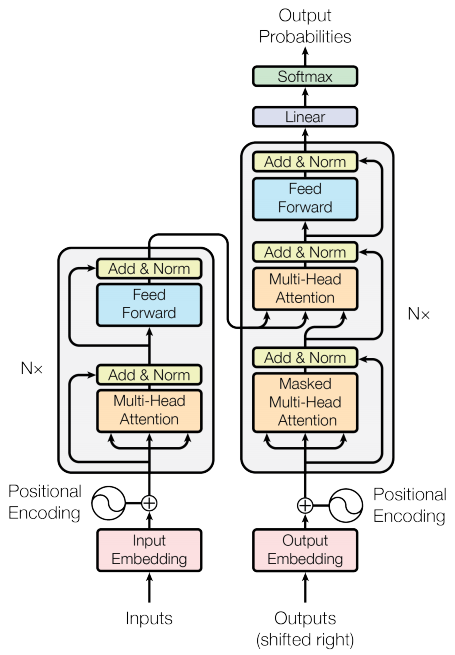

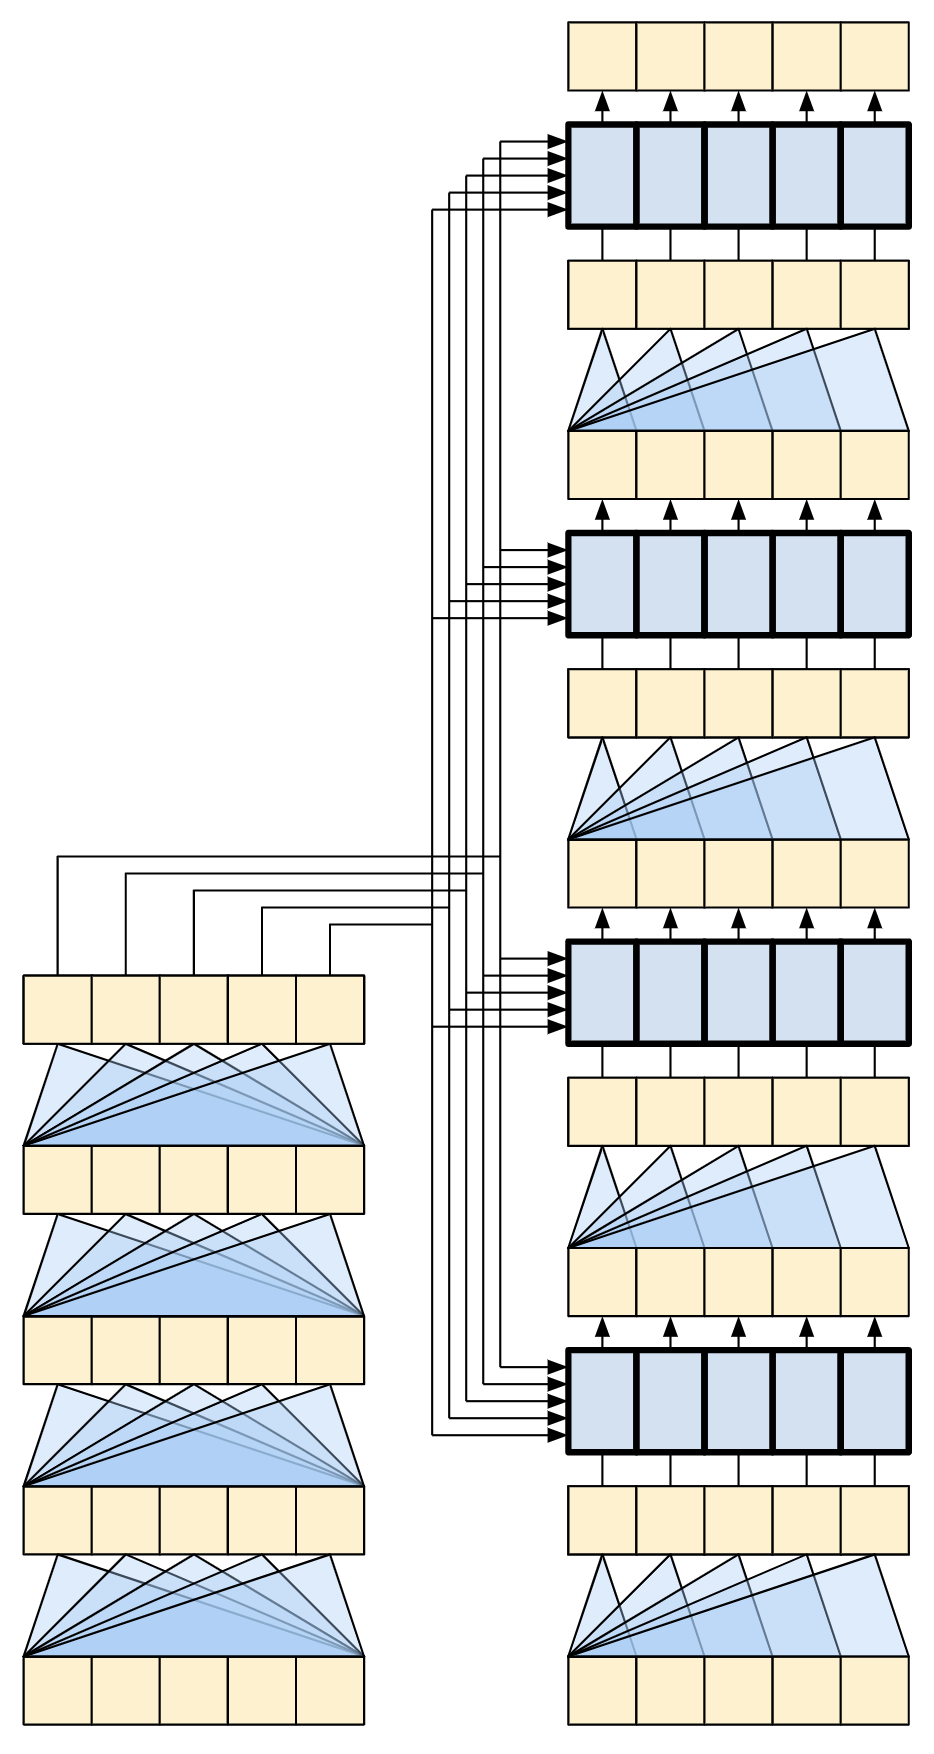

# GENERATION OF EMBEDDING AND POSITIONAL LAYER
1)The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a tf.keras.layers.Embedding layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a bag of words instance, how are you, how you are, you how are, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The original paper uses the following formula for calculating the positional encoding:

#PE(pos,2i)=sin(pos/100002i/dmodel)
#PE(pos,2i+1)=cos(pos/100002i/dmodel)

Note: The code below implements it, but instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated. Permuting the channels like this is functionally equivalent, and just a little easier to implement and show in the plots below.

In [ ]:
def positional_encoding(length,depth):
  depth = depth/2

  positions = np.arange(length)[:,np.newaxis]  # (seq, 1)
  depths = np.arange(depth)[np.newaxis,:]/depth  # (1, depth)

  angle_rates = 1/(10000**depths) # (1, depth)
  angle_rads = positions * angle_rates  # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads),np.cos(angle_rads)],axis=-1)
  return tf.cast(pos_encoding,dtype = tf.float32)

In [ ]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [ ]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = tf.cast(positional_encoding(length=2048, depth=d_model), dtype=tf.float32)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x




In [ ]:
vocab_pt = int(tokenizers.pt.get_vocab_size().numpy())
vocab_en = int(tokenizers.en.get_vocab_size().numpy())

embed_pt = PositionalEmbedding(vocab_size=vocab_pt, d_model=512)
embed_en = PositionalEmbedding(vocab_size=vocab_en, d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)


In [ ]:
en_emb._keras_mask

# ADD AND NORMALIZE LAYERS

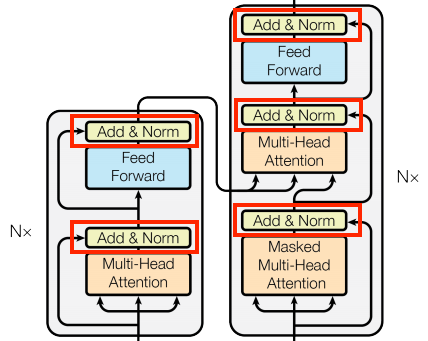

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a LayerNormalization layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each.

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are updated by the attention layers instead of replaced), while the normalization maintains a reasonable scale for the outputs.

# BASE ATTENTION LAYER

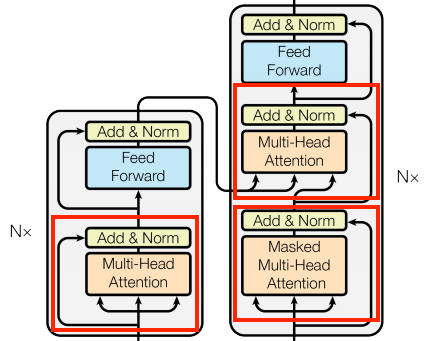

In [ ]:
# IMPLEMENTING BASE ATTENTION CLASS
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()




#ATTENTION REFRESHER

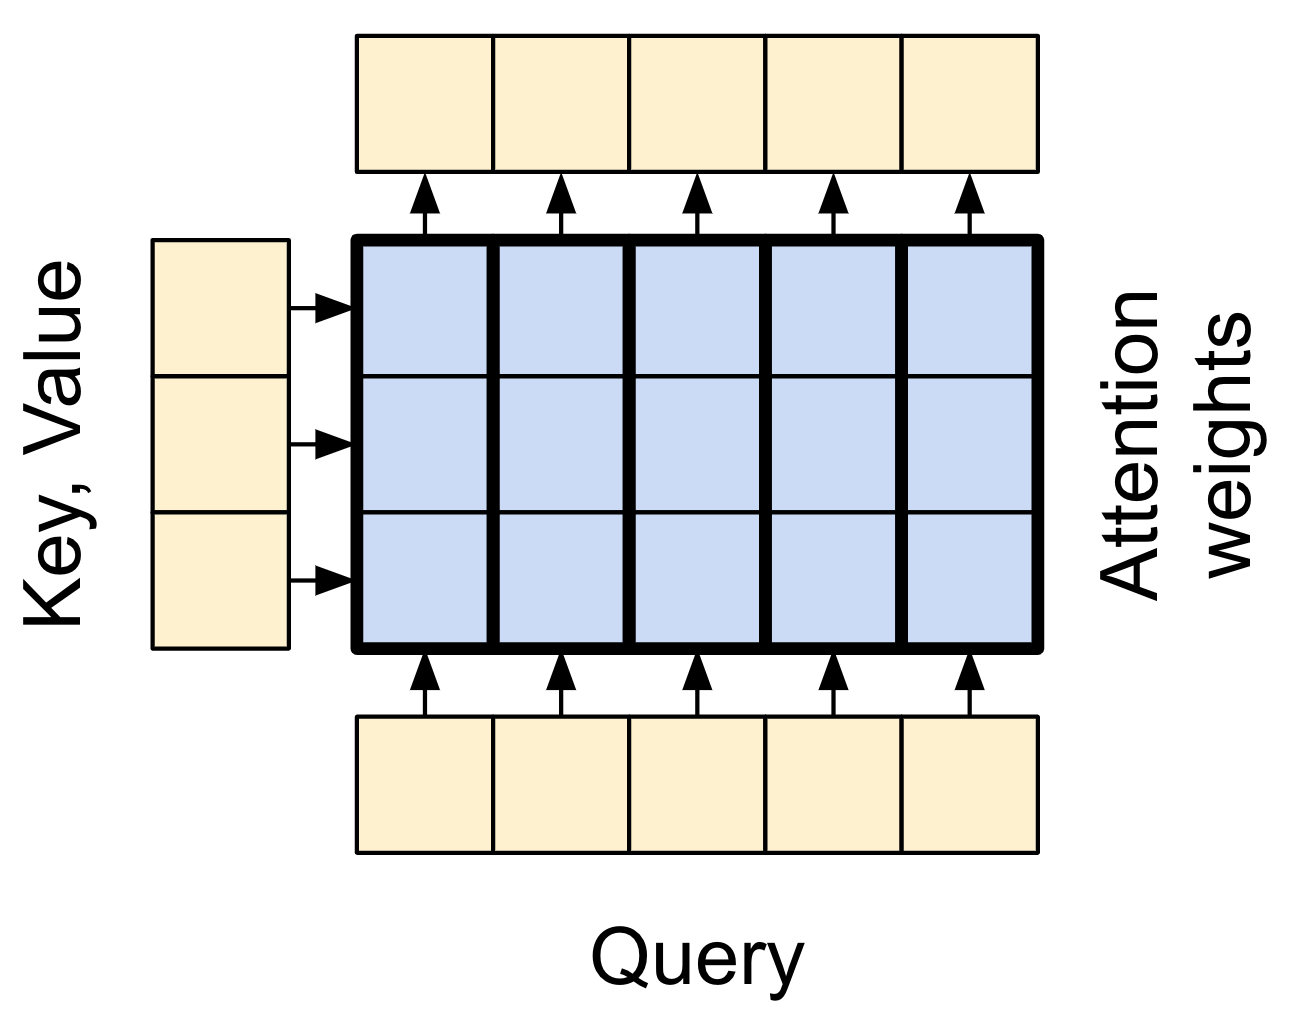

The querys is what you're trying to find.

The keys what sort of information the dictionary has.

The value is that information.

How does that work? In an attention layer the query, key, and value are each vectors. Instead of doing a hash lookup the attention layer combines the query and key vectors to determine how well they match, the "attention score". The layer returns the average across all the values, weighted by the "attention scores".


Each location the query-sequence provides a query vector. The context sequence acts as the dictionary. At each location in the context sequence provides a key and value vector. The input vectors are not used directly, the layers.MultiHeadAttention layer includes layers.Dense layers to project the input vectors before using them.

# CROSS ATTENTION

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model

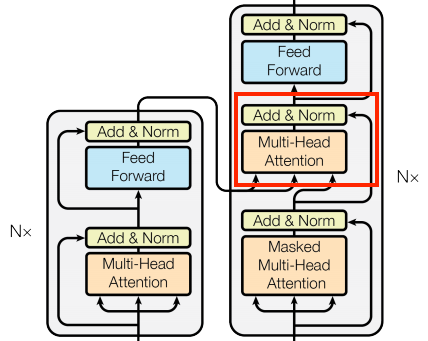

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [ ]:
class CrossAttention(BaseAttention):
  def call(self,x,context):
    attn_output,attn_score = self.mha(
        query = x,
        key = context,
        value = context,
        return_attention_scores = True
    )
    self.last_attn_scores = attn_score
    x = self.add([x,attn_output]) # RESIDUAL CONNECTION
    x = self.layernorm(x)

    return x


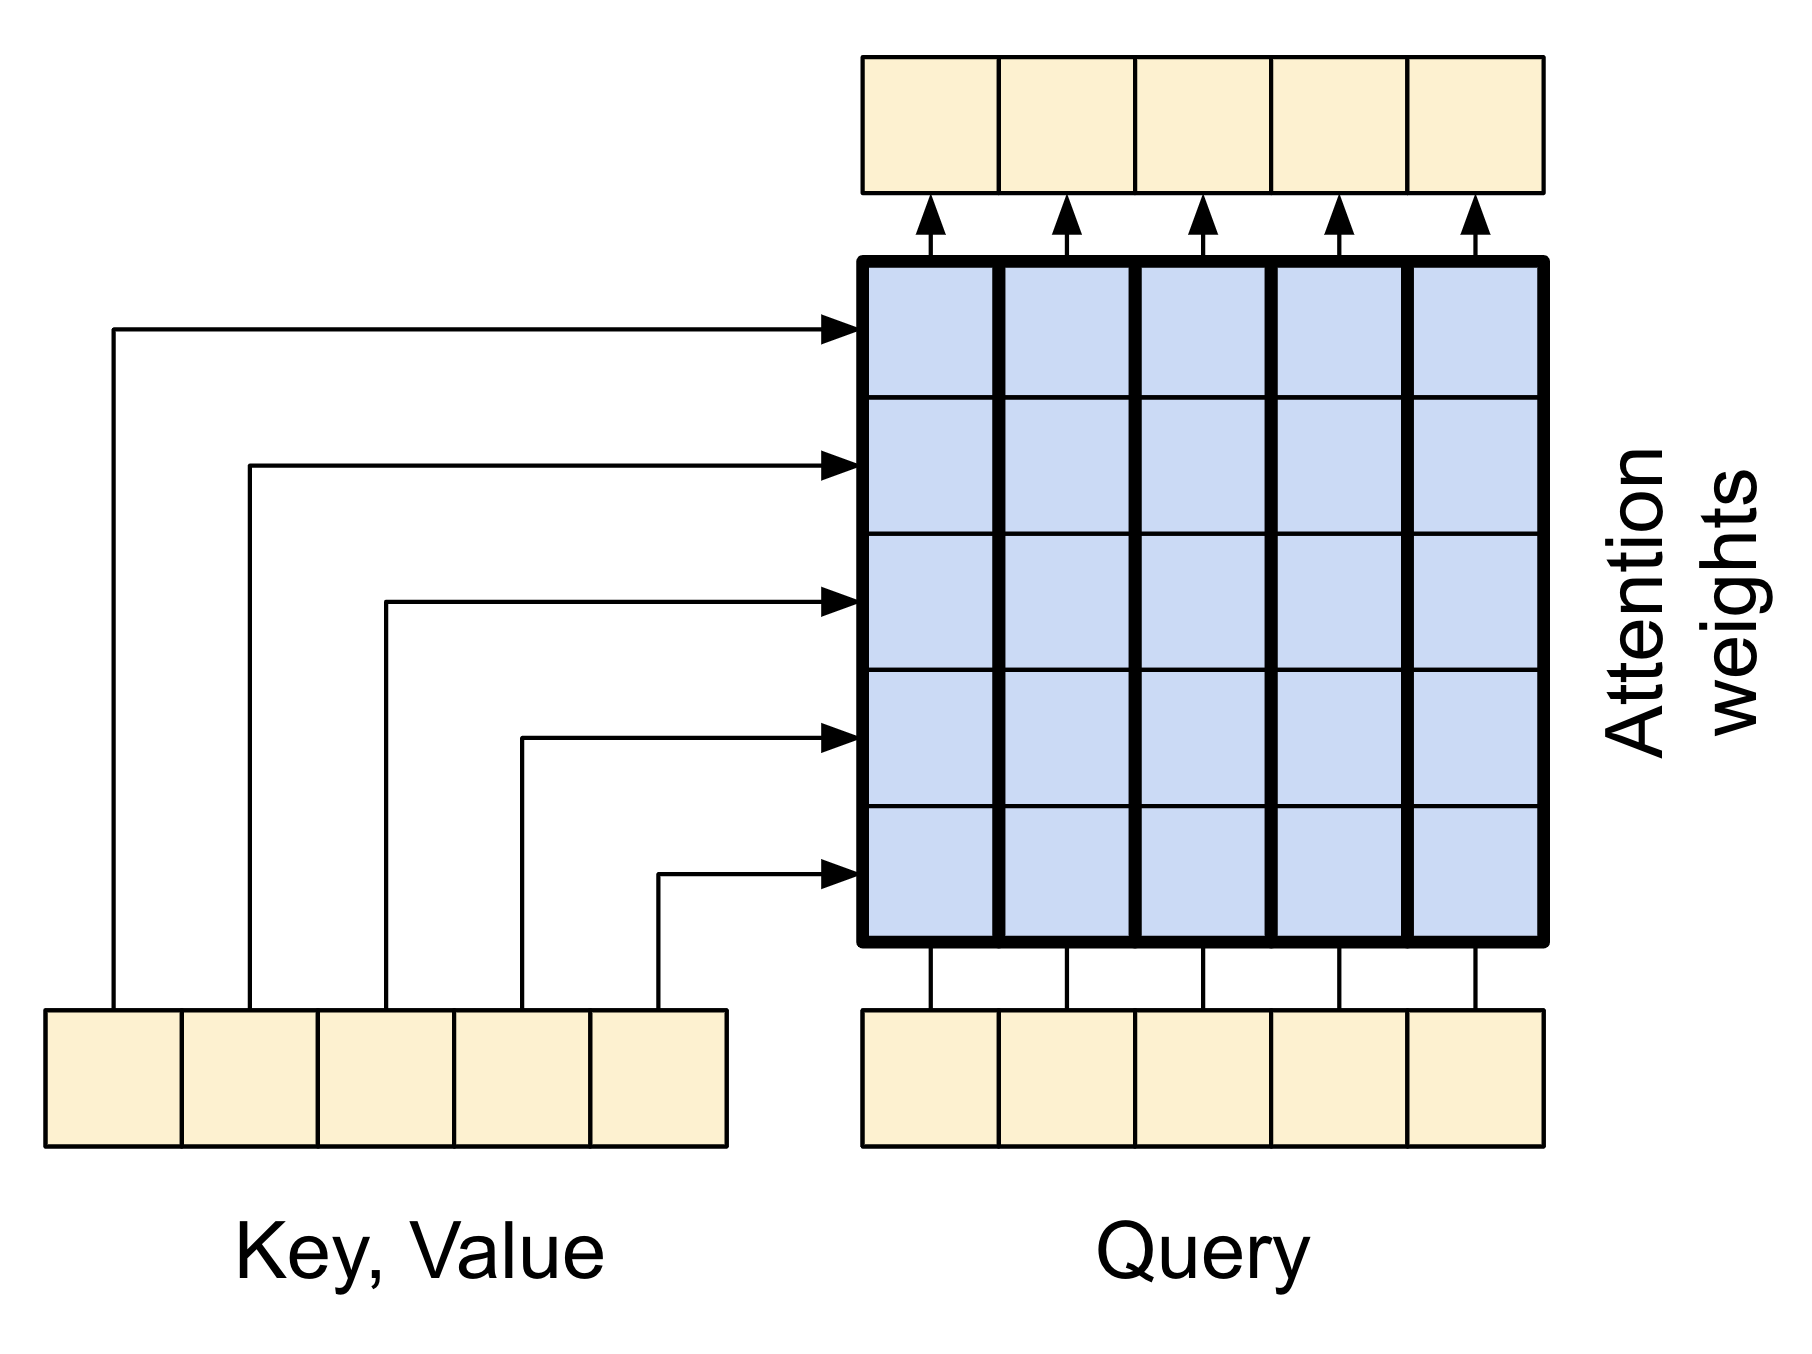

In [ ]:
sample_ca = CrossAttention(num_heads=2,key_dim = 512)
print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

# GLOBAL ATTENTION LAYER

This layer is responsible for processing the context sequence, and propagating information along its length:

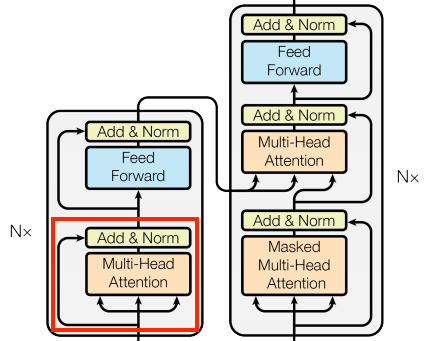

The global self-attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel.

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self,x):
    attn_output = self.mha(
        query = x,
        key = x,
        value = x)
    x = self.add([x,attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads = 2,key_dim = 512)# NUM_HEAD DEFINES THE NUMBER OF PARAELLEL SELF -ATTENTION
print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

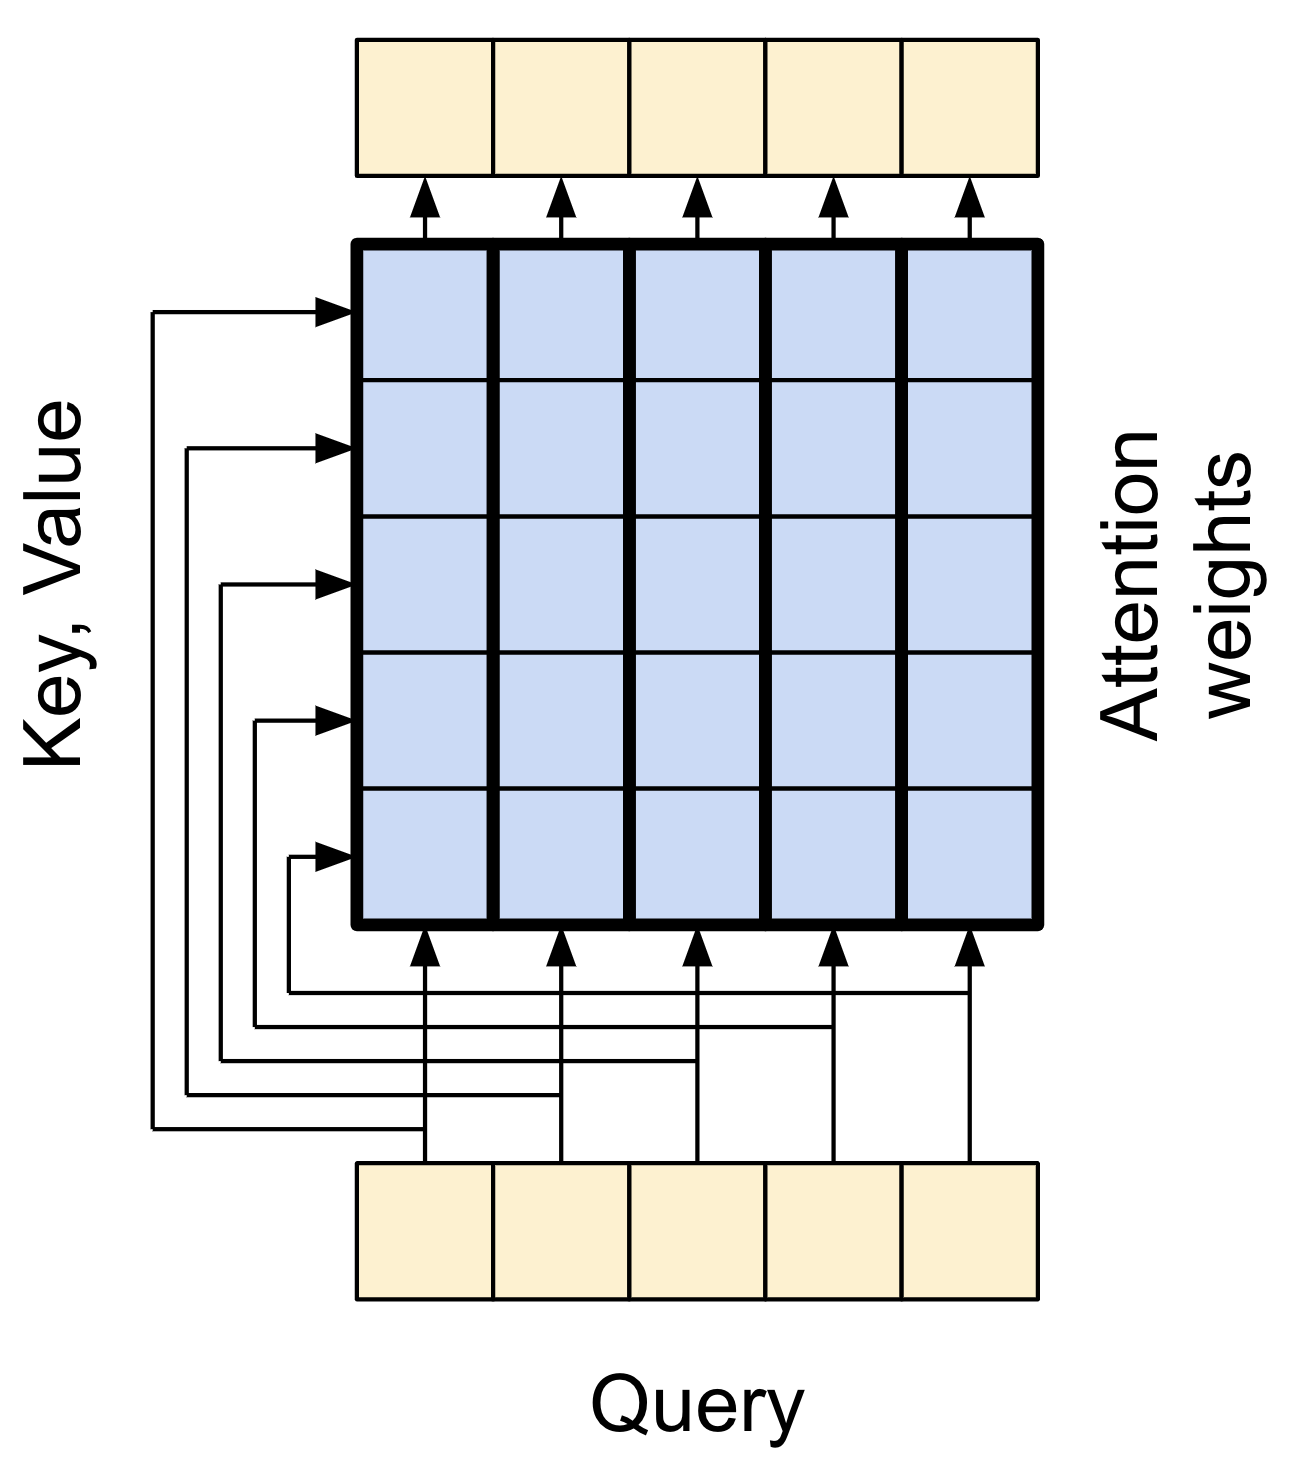

# CASUAL SELF ATTENTION
A mask is applied to ensure that a token can only attend to itself and the tokens before it, not the ones after it.

This prevents the model from "cheating" by looking at future tokens during training, which is critical for autoregressive tasks like text generation.

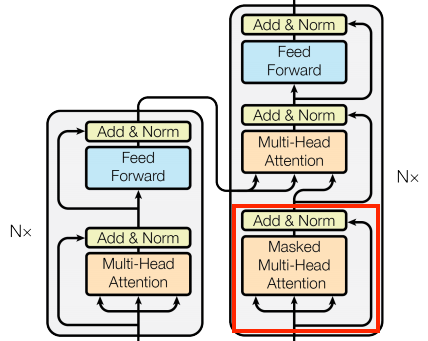

In [ ]:
class MaskedSelfAttention(BaseAttention):
  def call(self, x):
    # Apply causal masking using tf.linalg.band_part
    seq_len = tf.shape(x)[1]
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # Lower triangular mask

    attn_output = self.mha(
        query=x,
        key=x,
        value=x,
        attention_mask=mask  # Use attention_mask instead of causal_mask
    )
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

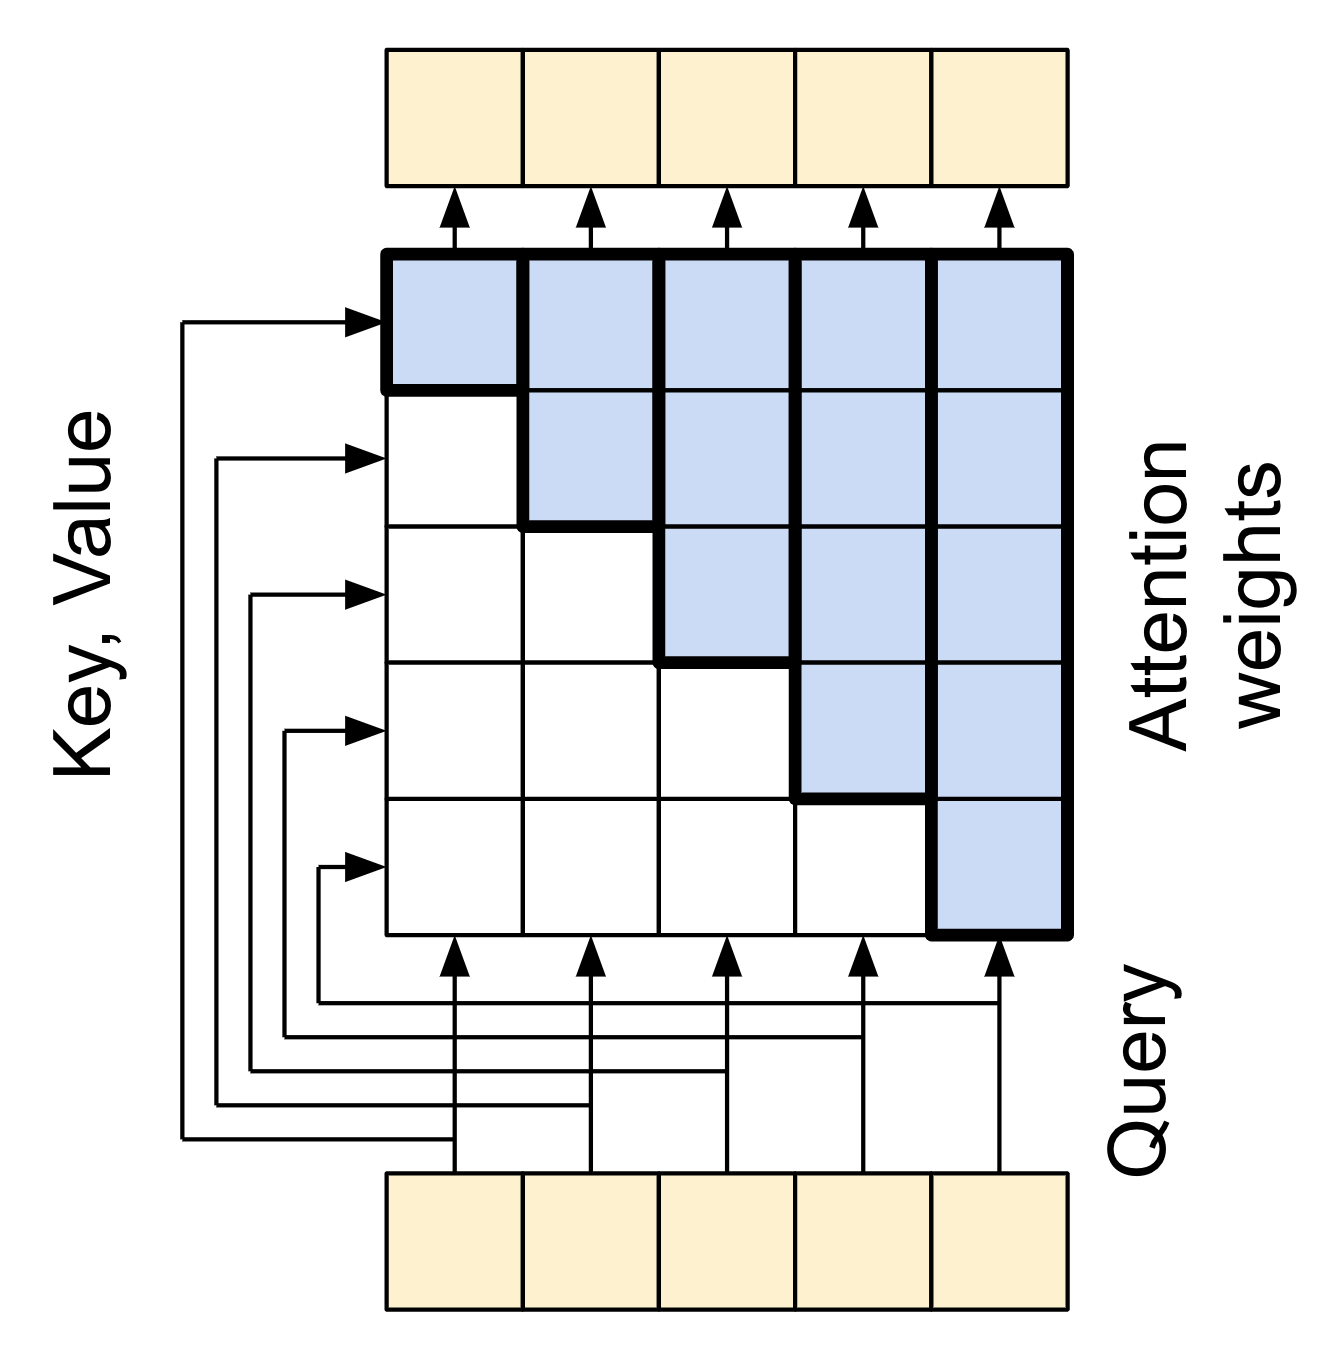

In [ ]:
sample_csa = MaskedSelfAttention(num_heads = 2,key_dim = 512)
print(en_emb.shape)
print(sample_csa(en_emb).shape)

In [ ]:
out1 = sample_csa(embed_en(en[:,:3]))
out2 = sample_csa(embed_en(en))[:,:3]
tf.reduce_max(abs(out1-out2)).numpy()

# FEED FORWARD NEURAL -NETWORK
The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

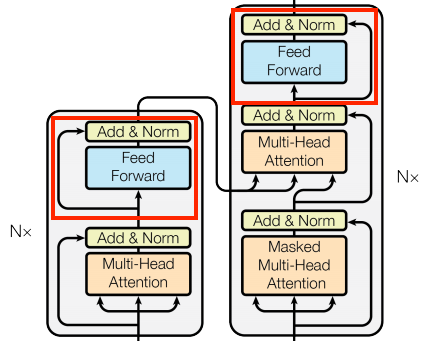

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self,d_model,dff,dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff,activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self,x):
      x = self.add([x,self.seq(x)])
      x = self.layer_norm(x)
      return x

In [ ]:
sample_ffn = FeedForward(512,2048)
print(en_emb.shape)
print(sample_ffn(en_emb).shape)

# ENCODER LAYER
 The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*,d_model,num_heads,dff,dropout_rate =0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate

    )
    self.ffn = FeedForward(d_model,dff)

  def call(self,x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x


In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

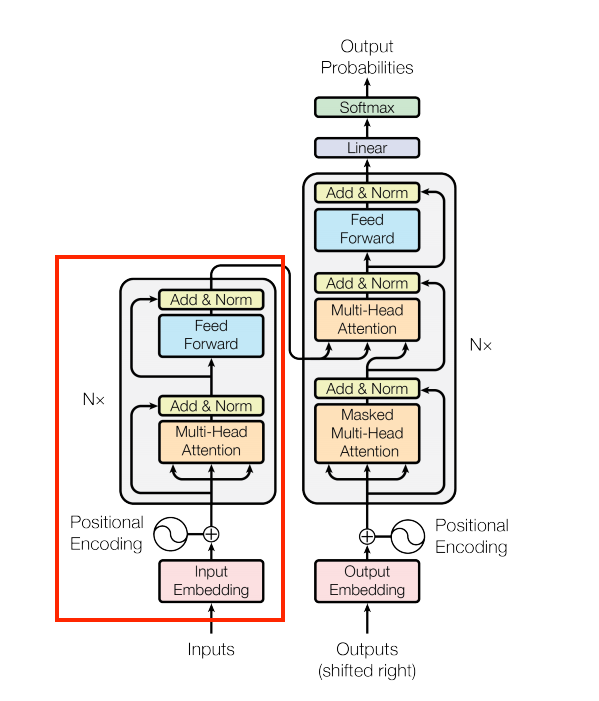

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*,num_layers,d_model,num_heads,dff,vocab_size,dropout_rate = 0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size = vocab_size,d_model = d_model
    )
    self.enc_layers = [
        EncoderLayer(d_model = d_model,
                     num_heads = num_heads,
                     dff= dff,
                     dropout_rate = dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self,x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x


In [ ]:
sample_encoder = Encoder(num_layers = 4,
                         d_model = 512,
                         num_heads =8,
                         dff = 2048,
                         vocab_size = 8500)
sample_encoder_output = sample_encoder(pt,training=False)
print(pt.shape)
print(sample_encoder_output.shape)

# DECODER LAYER
The decoder's stack is slightly more complex, with each DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer:

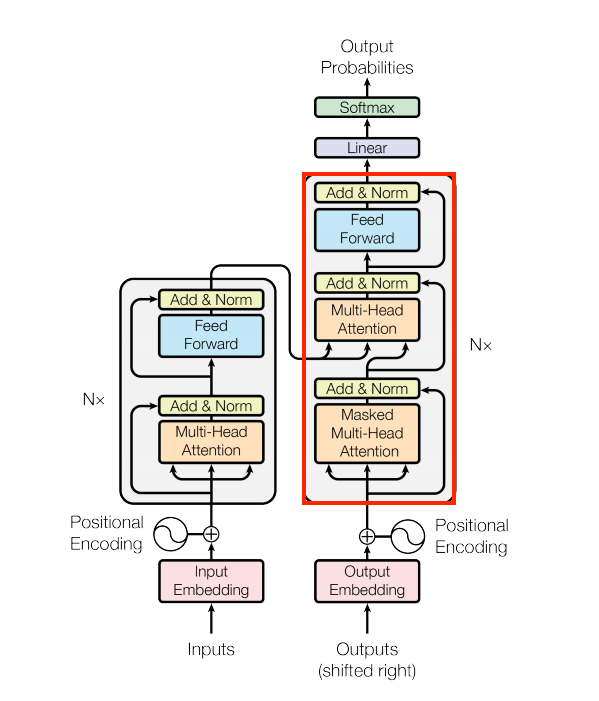

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*,d_model,num_heads,dff,dropout_rate=0.1):
    super(DecoderLayer,self).__init__()

    self.causal_self_attention = MaskedSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model,dff)

  def call(self,x,context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x,context = context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model = 512,num_heads= 8,dff= 2048)
sample_decoder_layer_output = sample_decoder_layer(
    x = en_emb,context = pt_emb
)
print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

# IMPLEMENTING  DECODER CLASS

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*,num_layers,d_model,num_heads,dff,vocab_size,dropout_rate = 0.1):
    super(Decoder,self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,d_model = d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model = d_model,num_heads = num_heads,dff=dff,dropout_rate = dropout_rate)
      for _ in range(num_layers)]
    self.last_attn_scores = None
  def call(self,x,context):
      x = self.pos_embedding(x)
      x = self.dropout(x)

      for i in range(self.num_layers):
        x = self.dec_layers[i](x,context)
      self.last_attn_scores = self.dec_layers[-1].last_attn_scores
       # The shape of x is (batch_size, target_seq_len, d_model).
      return x

In [ ]:
sample_decoder = Decoder(num_layers = 4,
                         d_model = 512,
                         num_heads = 8,
                         dff = 2048,
                         vocab_size = 8000)
output = sample_decoder(
    x = en,
    context = pt_emb
)
print(en.shape)
print(pt_emb.shape)
print(output.shape)

In [ ]:
sample_decoder.last_attn_scores.shape

# TRANSFORMER
-
A TRANSFORMER CONSIST OF BOTH ENCODER AND DECODER WITHIN ITSELF .THEREFORE WE PUT THEM TOGETHER AND ADD AN DENSE LAYER IN ORDER TO CONVERT OUTPUT VECTOR INTO RESULTANT PROBABILITIES.



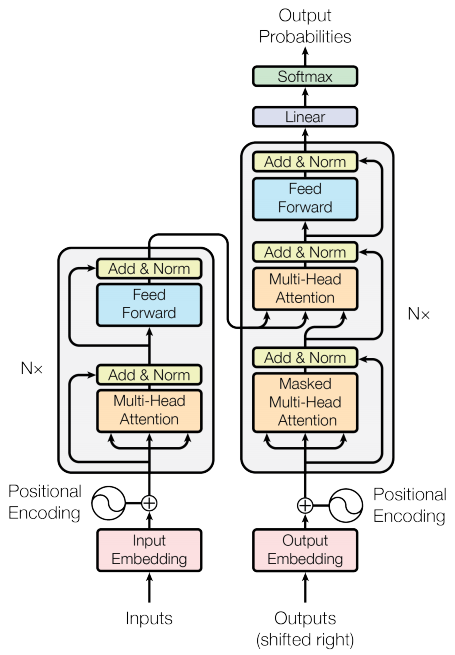

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,*,num_layers,d_model,num_heads,dff,input_vocab_size,target_vocab_size,dropout_rate = 0.1):
    super(Transformer,self).__init__()
    self.encoder = Encoder(num_layers = num_layers,
                           d_model = d_model,
                           num_heads = num_heads,
                           dff=dff,
                           vocab_size =input_vocab_size,
                           dropout_rate = dropout_rate)
    self.decoder = Decoder(num_layers = num_layers,
                           d_model = d_model,
                           num_heads = num_heads,
                           dff = dff,
                           vocab_size = target_vocab_size,
                           dropout_rate = dropout_rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)


  def call(self,inputs):
    context , x = inputs
    context = self.encoder(context) # (batch_size, context_len, d_model)
    x = self.decoder(x,context) # (batch_size, target_len, d_model)
      # Final linear layer output.
    logits = self.final_layer(x) # (batch_size, target_len, target_vocab_size)
    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
       del logits._keras_mask
    except AttributeError:
       pass

    # Return the final output and the attention weights.
    return logits



In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1


# INSTANTIATE TRANSFORMER

In [ ]:
transformer = Transformer(
    num_layers = num_layers,
    d_model = d_model,
    num_heads = num_heads,
    dff= dff,
    input_vocab_size = tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size = tokenizers.en.get_vocab_size().numpy(),
    dropout_rate = dropout_rate
)

In [ ]:
output = transformer((pt,en))
print(en.shape)
print(pt.shape)
print(output.shape)

In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape) # (batch, heads, target_seq, input_seq)

# TRAINING

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self,d_model,warmup_steps=4000):
    super().__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model,tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# LOSS FUNCTION

# TRAINING OUR MODEL

In [ ]:
def masked_loss(label, pred):
    # Mask where label is not 0 (non-padding tokens)
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    # Calculate loss
    loss = loss_object(label, pred)

    # Apply mask to the loss (only non-padding tokens contribute to the loss)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    # Check if there are any valid tokens (non-padding) in the mask
    mask_sum = tf.reduce_sum(mask)
    loss_sum = tf.reduce_sum(loss)

    # If no valid tokens, return 0 loss (or you can skip that batch, as appropriate)
    return tf.cond(mask_sum == 0, lambda: tf.constant(0.0), lambda: loss_sum / mask_sum)
def masked_accuracy(label, pred):
    # Get predicted class index (argmax along the sequence dimension)
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)

    # Match where label equals predicted token (ignoring padding)
    match = label == pred

    # Apply mask where label is not 0 (non-padding)
    mask = label != 0
    match = match & mask  # Only consider valid tokens for accuracy calculation

    # Calculate accuracy only for non-padding tokens
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    # Check if there are any valid tokens (non-padding) in the mask
    mask_sum = tf.reduce_sum(mask)

    # If no valid tokens, return 0 accuracy (or you can skip that batch)
    return tf.cond(mask_sum == 0, lambda: tf.constant(0.0), lambda: tf.reduce_sum(match) / mask_sum)


In [ ]:
transformer.compile(
    loss = masked_loss,
    optimizer = optimizer,
    metrics = [masked_accuracy]
)

In [ ]:
transformer.fit(train_batches,epochs=5,validation_data = val_batches)

534/810 ━━━━━━━━━━━━━━━━━━━━ 51:52 11s/step - loss: 7.9756 - masked_accuracy: 0.0766

# INFERENCING

In [ ]:
class Translator(tf.Module):
  def __init__(self,tokenizers,transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer
  def call(self,sentence,max_length = MAX_TOKENS):
    assert isinstance(sentence,tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]
    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    encoder_input = sentence
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights


In [ ]:
translator = Translator(tokenizers,transformer)

In [ ]:
def print_translation(sentence,tokens,ground_truth):
  print(f'{"Input:":15s}:{sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth);